In [2]:
!pip install torch

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.preprocessing import StandardScaler

In [4]:
data = pd.read_csv('./team_26.csv')

data.head()

,Corner,vsup,temperature,l55lp_v0101.lib.scs,l55lp_v0101.lib.scs.1,l55lp_v0101.lib.scs.2,Pass/Fail,"VDC(""/net13"")"
0,C0_0,1.6,-55,ss_lp_io25,ff_lp_rvt12,ff_lp_bjt,NaN,0.6249
1,C0_1,1.6,-50,ss_lp_io25,ff_lp_rvt12,ff_lp_bjt,NaN,0.6136
2,C0_2,1.6,-40,ss_lp_io25,ff_lp_rvt12,ff_lp_bjt,NaN,0.5908
3,C0_3,1.6,-30,ss_lp_io25,ff_lp_rvt12,ff_lp_bjt,NaN,0.5680
4,C0_4,1.6,-20,ss_lp_io25,ff_lp_rvt12,ff_lp_bjt,NaN,0.5452


In [5]:
def listOneHotEncoder(items) :
    
    # Finding  unique items
    unique_items = list(set(items))

    # Length of the given list
    no_items = len(items)

    # We will be returning a numpy array
    encoded = np.zeros((no_items, 1))

    for i, item in enumerate(items) :
        encoded[i] = unique_items.index(item)

    return encoded

In [6]:
class CadenceDataset(Dataset) :

    def __init__(self) :

        # Loading data
        data = pd.read_csv('./team_26.csv')

        # The following 5 values are the inputs
        vsup = np.array(data['vsup']).reshape(-1, 1)
        temperature = np.array(data['temperature']).reshape(-1, 1)
        model1 = listOneHotEncoder(data['l55lp_v0101.lib.scs'])
        model2 = listOneHotEncoder(data['l55lp_v0101.lib.scs.1'])
        model3 = listOneHotEncoder(data['l55lp_v0101.lib.scs.2'])

        # Concatenating them
        self.x = np.concatenate((vsup, temperature, model1, model2, model3), axis=1)
        
        # Corresponding outputs
        self.y = np.array(data['VDC("/net13")']).reshape(-1, 1)

        # Scaling the data
        self.x = StandardScaler().fit_transform(self.x)

        # Converting both to tensor
        self.x = torch.from_numpy(self.x)
        self.y = torch.from_numpy(self.y)

        # Saving the number of samples
        self.length = len(self.x)

    def __getitem__(self, index) :
        return self.x[index].float(), self.y[index].float()

    def __len__(self) :
        return self.length

In [7]:
dataset = CadenceDataset()

In [8]:
# Splitting the data for training and testing
train_dataset, test_dataset = random_split(dataset, [4131, 2754])

In [9]:
# Generating dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=True)

### Linear Regression

In [10]:
X_train = train_dataset[:][0]
Y_train = train_dataset[:][1]

X_test = test_dataset[:][0]
Y_test = test_dataset[:][1]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [55]:
LinearModel = LinearRegression()

reg = LinearModel.fit(X_train, Y_train)

In [56]:
def MSE(a, b) :
    return np.mean((a-b)**2)

In [57]:
# Calculating the accuracy using R2 metric
pred = reg.predict(X_test)

print(f"R2 score for the linear regression model is {r2_score(Y_test, pred)}")

R2 score for the linear regression model is 0.8639347502375687


### Multi Layer Perceptron

In [15]:
# Defining the model

model = nn.Sequential(
    nn.Linear(5, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

In [16]:
# Defining optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Defining scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Defining criterion
criterion = nn.MSELoss()

In [17]:
# Training function
def train(optimizer, scheduler, criterion, epochs=10) :
    for e in range(epochs):
        train_loss = 0.0
        
        for data, labels in tqdm(train_dataloader):
            # Transfer Data to GPU if available
            if torch.cuda.is_available():
                print("yes")
                data, labels = data.cuda(), labels.cuda()
            
            # Clear the gradients
            optimizer.zero_grad()
            # Forward Pass
            target = model(data)
            # Find the Loss
            loss = criterion(target,labels)
            # Calculate gradients 
            loss.backward()
            # Update Weights
            optimizer.step()
            # Calculate Loss
            train_loss += loss.item()
        
        scheduler.step()

        # print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)}')

In [18]:
train(optimizer, scheduler, criterion, 20)

  0%|          | 0/1033 [00:00<?, ?it/s]

yes


  0%|          | 0/1033 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
# Finding out the predictions
pred = model(X_test)

# Calculating the R2 score
print(f'R2 Score for MLP is {r2_score(Y_test.numpy(), pred.detach().numpy())}')

R2 Score for MLP is 0.994831244341355


In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [20]:
degrees=[1,3,5,7,9,11]
scores = []
for degree in degrees:
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X_train, Y_train)
    pred = polyreg.predict(X_test)
    scores.append(r2_score(Y_test, pred))
    print(f"R2 score for the polynomial regression model with degree = {degree} is {r2_score(Y_test, pred)}")

R2 score for the polynomial regression model with degree = 1 is 0.8639347421265047
R2 score for the polynomial regression model with degree = 3 is 0.9592271619438424
R2 score for the polynomial regression model with degree = 5 is 0.9840154953561289
R2 score for the polynomial regression model with degree = 7 is 0.9927875293995314
R2 score for the polynomial regression model with degree = 9 is 0.9965577488559604
R2 score for the polynomial regression model with degree = 11 is 0.9971212248167223


In [21]:
pred = reg.predict(X_test)

print(f"R2 score for the linear regression model is {r2_score(Y_test, pred)}")

R2 score for the linear regression model is 0.8639347502375687


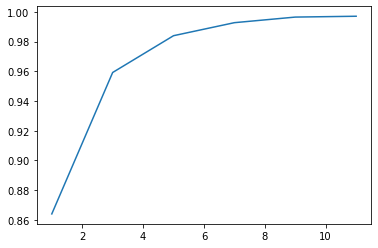

In [24]:
plt.plot(degrees,scores)

In [25]:
from sklearn.ensemble import RandomForestRegressor


In [33]:
scores = []
for depth in [2,4,6,8]:
    regr = RandomForestRegressor(max_depth=depth, random_state=0)
    regr.fit(X_train, Y_train)
    pred = regr.predict(X_test)
    scores.append(r2_score(Y_test, pred))
    print(f"R2 score for the linear regression model is {r2_score(Y_test, pred)}")

/tmp/ipykernel_396460/996560670.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)
/tmp/ipykernel_396460/996560670.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9385219655909074
R2 score for the linear regression model is 0.9810371022470323


/tmp/ipykernel_396460/996560670.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9943829441559368


/tmp/ipykernel_396460/996560670.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9991500426269205


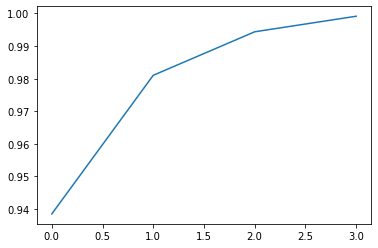

In [34]:
plt.plot(scores)

In [42]:
scores = []
for rs in [0,1,2,3]:
    regr = RandomForestRegressor(max_depth=8, random_state=rs)
    regr.fit(X_train, Y_train)
    pred = regr.predict(X_test)
    scores.append(r2_score(Y_test, pred))
    print(f"R2 score for the linear regression model is {r2_score(Y_test, pred)}")

/tmp/ipykernel_396460/752460570.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9991500426269205


/tmp/ipykernel_396460/752460570.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9991531786326014


/tmp/ipykernel_396460/752460570.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9991499245983714


/tmp/ipykernel_396460/752460570.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train, Y_train)


R2 score for the linear regression model is 0.9991315682631473


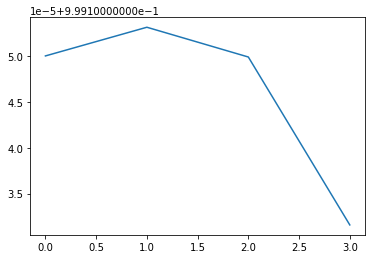

In [44]:
plt.plot([0,1,2,3],scores)

In [45]:
scores

[0.9991500426269205,
 0.9991531786326014,
 0.9991499245983714,
 0.9991315682631473]